In [1]:
import torch
from train import train_model
from dataset.utils import *
from utils import *
import numpy as np
import pickle
import time

In [2]:
batch_size = 128
def redefine_train_parameters(train_dataset):
    global device, epochs, learning_rate, loss_lr, num_classes, embedding_size, image_size
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    epochs = 50
    learning_rate = 0.001
    loss_lr = 0.01
    try: num_classes = get_num_classes(train_dataset)
    except: pass
    embedding_size = 512
    image_size = 100
redefine_train_parameters(0)

In [3]:
def train(
    train_loader,
    verbose=0,
    pretrained=1,
    save_path=None,
    model_name='resnet50',
    optimizer='adam',
    loss_func_name='proxy_anchor',
    use_loss_optimizer=False,
    drop_last=False):
    model = train_model(model_name=model_name,
                    loss_func_name=loss_func_name,
                    num_classes=num_classes,
                    dataloader=train_loader,
                    optimizer=optimizer,
                    embedding_size=embedding_size,
                    epochs=epochs,
                    learning_rate=learning_rate,
                    verbose=verbose,
                    use_loss_optimizer=use_loss_optimizer,
                    save_path=save_path)
    return model

In [4]:
def train_eval(name,base_name,enhance_params,
               loss_func_name='proxy_anchor',
               model_name='resnet50',
               drop_last=False,
               eval_only=False,
               gfpgan=False,
               load_saved=False
              ):
    global test_params, num_classes
    
    if load_saved:
        loaded_output = load_output()
        r1,r2,r4,r8,r16,r32 = loaded_output[f'train_{name}']
        print(f'''Train:
R@1: {r1*100}
R@2: {r2*100}
R@4: {r4*100}
R@8: {r8*100}
R@16: {r16*100}
R@32: {r32*100}''')
        r1,r2,r4,r8,r16,r32 = loaded_output[f'test_{name}']
        print(f'''Test:
R@1: {r1*100}
R@2: {r2*100}
R@4: {r4*100}
R@8: {r8*100}
R@16: {r16*100}
R@32: {r32*100}''')
        map_r = loaded_output[f'mapr_{name}']
        print(f'MAP@R: {map_r*100}')
        acc = loaded_output[f'accuracy_{name}']
        print(f'''Accuracy: {acc[0]}
Threshold: {acc[1]}''')
        labels = loaded_output[f'labels']
        sim_scores = loaded_output[f'sim_scores_{name}']
        visualize(labels,sim_scores)
    else:
        preprocess_dataset(enhance_params, gfpgan)
        train_dataset = make_dataset(
            'LFW',
            **train_params,
        )
    #     norm_mean,norm_std=normalize_dataset([train_dataset])
        norm_mean,norm_std=calc_mean_std(train_dataset, batch_size)
        print(norm_mean,norm_std)
        normalize_params = {
            'normalize': 1,
            'norm_mean': norm_mean,
            'norm_std': norm_std
        }

        train_dataset = make_dataset(
            'LFW',
            **train_params,
            **normalize_params
        )
        test_dataset = make_dataset(
            'LFW',
            **test_params,
            **normalize_params
        )
        redefine_train_parameters(train_dataset)
        train_loader = load_dataset(train_dataset, batch_size, shuffle=True, drop_last=False)
        test_loader = load_dataset(test_dataset, batch_size, shuffle=False, drop_last=False)
        if eval_only:
            model = torch.load(f'./saved_models/{name}.ptm')
        else:
            model = train(train_loader,
                          save_path=f'./saved_models/{name}.ptm',
                          loss_func_name=loss_func_name,
                          model_name=model_name,
                          drop_last=False
                         )
        model.eval()
        with torch.no_grad():
            save_output(evaluate_cos(model,train_loader),f'train_{name}')
            save_output(evaluate_cos(model,test_loader),f'test_{name}')
            save_output(mapr(model, base_name, test_loader),f'mapr_{name}')
            test_pair_dataset = make_dataset(
                'LFWPairs',
                **test_params,
                **normalize_params
            )
            labels,sim_scores = evaluate(model,test_pair_dataset)
            save_output(labels, 'labels')
            save_output(sim_scores, f'sim_scores_{name}')
            far,tar,thresholds=roc_curve(labels,sim_scores)
            save_output(tar_at_far(tar,far), f'tar@far_{name}')
            save_output(accuracy(labels,sim_scores,thresholds), f'accuracy_{name}')
            visualize(labels,sim_scores)

In [5]:
train_params = {
    'split': 'train',
    'random': 1,
    'random_resized_crop': image_size
}
test_params = {
    'split': 'test',
    'random': 0,
    'image_size': image_size,
}

Files already downloaded and verified
Files already downloaded and verified
tensor([0.4832, 0.4029, 0.3486]) tensor([0.2805, 0.2506, 0.2444])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [26/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [27/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [28/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [29/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [30/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [31/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [32/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [33/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [34/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [35/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [36/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [37/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [38/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [39/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [40/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [41/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [42/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [43/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [44/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 629.4869 Best loss: 8.4035


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 27.822
R@2 : 33.890
R@4 : 39.181
R@8 : 44.010
R@16 : 47.916
R@32 : 50.719


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 22.465
R@2 : 28.182
R@4 : 33.387
R@8 : 38.403
R@16 : 43.258
R@32 : 47.708


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 8.3334
Files already downloaded and verified


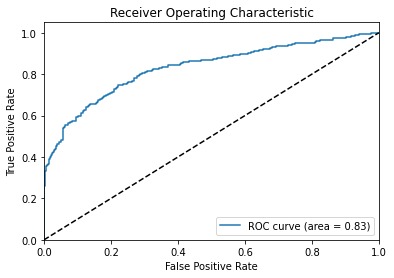

TAR@FAR:
    1%: 0.5940
  0.1%: 0.3600
 0.01%: 0.2600
0.001%: 0.2600
Accuracy: 0.761, Threshold: 0.6921833753585815


In [6]:
name='PA'
enhance_params = {}
train_eval(name,'PA',enhance_params)

Files already downloaded and verified
==> Computing mean and std..


  0%|          | 0/9525 [00:00<?, ?it/s]

tensor([0.4827, 0.4024, 0.3478]) tensor([0.2466, 0.2185, 0.2094])
time elapsed:  10.103613138198853
PA+FaceDetection(pad_ratio=1)
Files already downloaded and verified


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 15.534
R@2 : 20.604
R@4 : 26.645
R@8 : 32.848
R@16 : 38.188
R@32 : 43.689


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 4.9709
Files already downloaded and verified


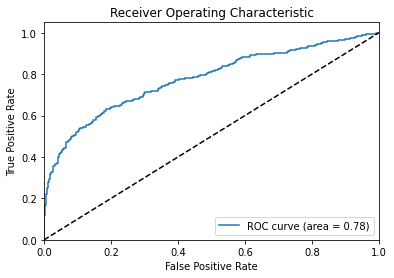

TAR@FAR:
    1%: 0.5200
  0.1%: 0.2520
 0.01%: 0.1200
0.001%: 0.1200
Accuracy: 0.721, Threshold: 0.6552258133888245
PA+FaceDetection(pad_ratio=1.2)
Files already downloaded and verified


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 20.038
R@2 : 25.728
R@4 : 30.663
R@8 : 35.895
R@16 : 40.858
R@32 : 46.386


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 6.9225
Files already downloaded and verified


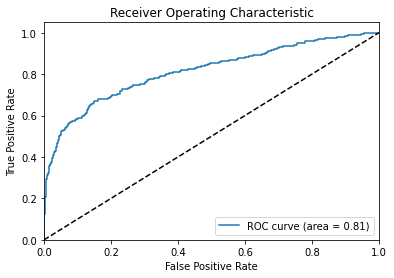

TAR@FAR:
    1%: 0.5860
  0.1%: 0.3120
 0.01%: 0.1260
0.001%: 0.1260
Accuracy: 0.759, Threshold: 0.6861120462417603
PA+FaceDetection(pad_ratio=1.4)
Files already downloaded and verified


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 21.386
R@2 : 27.346
R@4 : 32.362
R@8 : 37.325
R@16 : 42.314
R@32 : 47.087


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 7.8459
Files already downloaded and verified


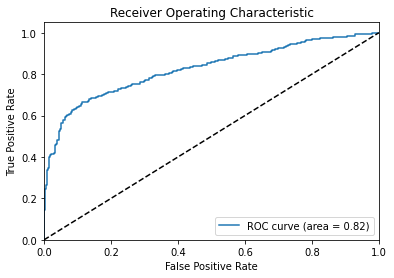

TAR@FAR:
    1%: 0.6400
  0.1%: 0.3380
 0.01%: 0.1420
0.001%: 0.1420
Accuracy: 0.775, Threshold: 0.7071931958198547
PA+FaceDetection(pad_ratio=1.6)
Files already downloaded and verified


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 22.573
R@2 : 27.346
R@4 : 32.443
R@8 : 37.729
R@16 : 42.557
R@32 : 47.276


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 8.3331
Files already downloaded and verified


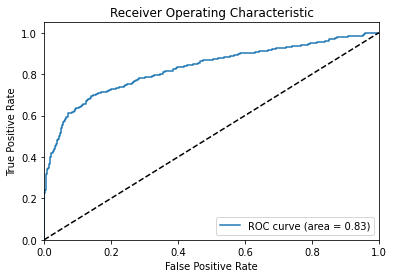

TAR@FAR:
    1%: 0.6360
  0.1%: 0.3400
 0.01%: 0.2260
0.001%: 0.2260
Accuracy: 0.777, Threshold: 0.7069565653800964
PA+FaceDetection(pad_ratio=1.8)
Files already downloaded and verified


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 22.465
R@2 : 27.859
R@4 : 32.956
R@8 : 38.080
R@16 : 42.907
R@32 : 47.465


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 8.4681
Files already downloaded and verified


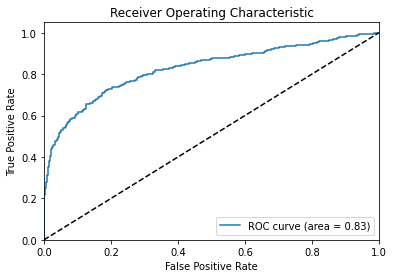

TAR@FAR:
    1%: 0.6120
  0.1%: 0.3120
 0.01%: 0.2160
0.001%: 0.2160
Accuracy: 0.768, Threshold: 0.7025381922721863
PA+FaceDetection(pad_ratio=2)
Files already downloaded and verified


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 21.845
R@2 : 26.861
R@4 : 32.983
R@8 : 38.080
R@16 : 42.449
R@32 : 47.168


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 8.3325
Files already downloaded and verified


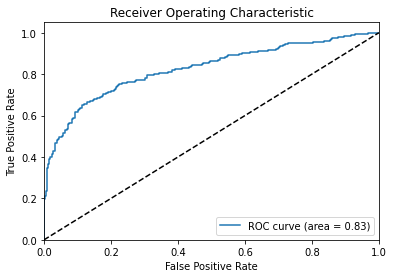

TAR@FAR:
    1%: 0.6220
  0.1%: 0.3480
 0.01%: 0.1980
0.001%: 0.1980
Accuracy: 0.768, Threshold: 0.7201972007751465


In [7]:
train_dataset = make_dataset(
    'LFW',
    **train_params,
)
norm_mean,norm_std=normalize_dataset([train_dataset])
print('====================================')
normalize_params = {
    'normalize': 1,
    'norm_mean': norm_mean,
    'norm_std': norm_std
}

model = torch.load('./saved_models/PA.ptm')
model.eval()
with torch.no_grad():
    for pad_ratio in [1,1.2,1.4,1.6,1.8,2]:
        test_params = {
            'split': 'test',
            'random': 0,
            'image_size': image_size,
            'face_detection': 1,
            'pad_ratio': pad_ratio
        }
        name=f'PA+FaceDetection(pad_ratio={pad_ratio})'
        print(name)
        test_dataset = make_dataset(
            'LFW',
            **test_params,
            **normalize_params
        )
        test_loader = load_dataset(test_dataset, batch_size, shuffle=False, drop_last=False)
        save_output(evaluate_cos(model,test_loader),f'test_{name}')
        save_output(mapr(model, 'PA', test_loader),f'mapr_{name}')
        test_pair_dataset = make_dataset(
            'LFWPairs',
            **test_params,
            **normalize_params
        )
        labels,sim_scores = evaluate(model,test_pair_dataset)
        save_output(labels, 'labels')
        save_output(sim_scores, f'sim_scores_{name}')
        visualize(labels,sim_scores)
        print('====================================')

In [8]:
train_params = {
    'split': 'train',
    'random': 1,
    'random_resized_crop': image_size
}
test_params = {
    'split': 'test',
    'random': 0,
    'image_size': image_size,
}

Files already downloaded and verified


Preprocessing Dataset...:   0%|          | 0/13233 [00:00<?, ?it/s]

Files already downloaded and verified
tensor([0.4829, 0.4042, 0.3486]) tensor([0.2820, 0.2536, 0.2464])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [26/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [27/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [28/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [29/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [30/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [31/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [32/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [33/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [34/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [35/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [36/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [37/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [38/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [39/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [40/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [41/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [42/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [43/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [44/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 456.6502 Best loss: 8.3655


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 25.459
R@2 : 30.562
R@4 : 35.633
R@8 : 40.672
R@16 : 44.861
R@32 : 47.759


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 19.283
R@2 : 24.380
R@4 : 29.666
R@8 : 34.385
R@16 : 39.293
R@32 : 44.067


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 6.6019
Files already downloaded and verified


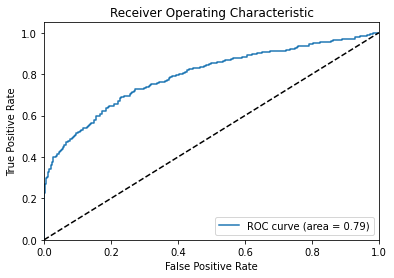

TAR@FAR:
    1%: 0.5200
  0.1%: 0.3040
 0.01%: 0.2240
0.001%: 0.2240
Accuracy: 0.728, Threshold: 0.7185605764389038


In [10]:
name='PA+MeanUnsharp(size=3)'
enhance_params = {
    'image_size': image_size,
    'mean_unsharp': 1,
    'mean_unsharp_size': 3,
    'mean_unsharp_amount': 1
}
train_eval(name,'PA',enhance_params)

Files already downloaded and verified


Preprocessing Dataset...:   0%|          | 0/13233 [00:00<?, ?it/s]

Files already downloaded and verified
tensor([0.4833, 0.4054, 0.3505]) tensor([0.2902, 0.2620, 0.2539])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [26/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [27/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [28/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [29/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [30/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [31/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [32/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [33/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [34/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [35/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [36/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [37/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [38/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [39/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [40/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [41/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [42/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [43/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [44/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 458.1632 Best loss: 8.4466


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 24.210
R@2 : 29.354
R@4 : 34.373
R@8 : 38.688
R@16 : 42.488
R@32 : 45.470


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 18.528
R@2 : 23.382
R@4 : 29.477
R@8 : 34.115
R@16 : 39.024
R@32 : 43.851


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 6.1742
Files already downloaded and verified


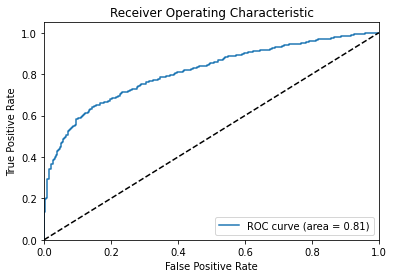

TAR@FAR:
    1%: 0.5860
  0.1%: 0.2920
 0.01%: 0.1340
0.001%: 0.1340
Accuracy: 0.748, Threshold: 0.709687352180481


In [11]:
name='PA+MeanUnsharp(size=5)'
enhance_params = {
    'image_size': image_size,
    'mean_unsharp': 1,
    'mean_unsharp_size': 5,
    'mean_unsharp_amount': 1
}
train_eval(name,'PA',enhance_params)

Files already downloaded and verified


Preprocessing Dataset...:   0%|          | 0/13233 [00:00<?, ?it/s]

Files already downloaded and verified
tensor([0.4815, 0.4016, 0.3482]) tensor([0.2776, 0.2487, 0.2425])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [26/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [27/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [28/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [29/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [30/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [31/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [32/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [33/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [34/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [35/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [36/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [37/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [38/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [39/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [40/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [41/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [42/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [43/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [44/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 459.9205 Best loss: 8.3391


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 27.738
R@2 : 33.638
R@4 : 38.310
R@8 : 42.604
R@16 : 46.320
R@32 : 48.535


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 21.117
R@2 : 26.187
R@4 : 31.149
R@8 : 36.165
R@16 : 40.372
R@32 : 44.714


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 7.2131
Files already downloaded and verified
TAR@FAR:
    1%: 0.5460
  0.1%: 0.3300
 0.01%: 0.1080
0.001%: 0.1080
Accuracy: 0.736, Threshold: 0.750009298324585


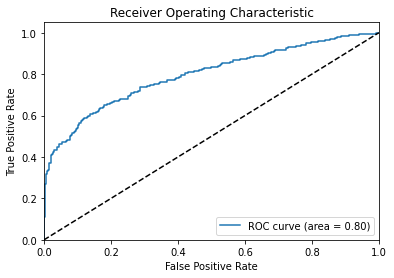

TAR@FAR:
    1%: 0.5460
  0.1%: 0.3300
 0.01%: 0.1080
0.001%: 0.1080


In [12]:
name='PA+MedianUnsharp(size=3)'
enhance_params = {
    'image_size': image_size,
    'median_unsharp': 1,
    'median_unsharp_size': 3,
    'median_unsharp_amount': 1
}
train_eval(name,'PA',enhance_params)

Files already downloaded and verified


Preprocessing Dataset...:   0%|          | 0/13233 [00:00<?, ?it/s]

Files already downloaded and verified
tensor([0.4789, 0.4004, 0.3477]) tensor([0.2814, 0.2531, 0.2465])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [26/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [27/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [28/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [29/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [30/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [31/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [32/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [33/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [34/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [35/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [36/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [37/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [38/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [39/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [40/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [41/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [42/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [43/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [44/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 462.0076 Best loss: 8.3431


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 26.908
R@2 : 32.703
R@4 : 37.533
R@8 : 42.016
R@16 : 45.417
R@32 : 48.115


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 18.878
R@2 : 24.218
R@4 : 29.153
R@8 : 33.819
R@16 : 39.266
R@32 : 44.552


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 6.3796
Files already downloaded and verified
TAR@FAR:
    1%: 0.4980
  0.1%: 0.3060
 0.01%: 0.2200
0.001%: 0.2200
Accuracy: 0.712, Threshold: 0.7575587630271912


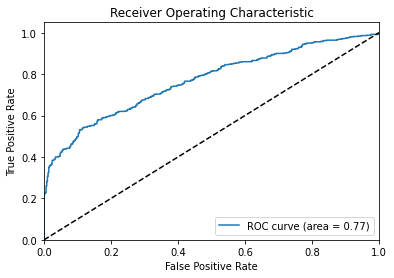

TAR@FAR:
    1%: 0.4980
  0.1%: 0.3060
 0.01%: 0.2200
0.001%: 0.2200


In [13]:
name='PA+MedianUnsharp(size=5)'
enhance_params = {
    'image_size': image_size,
    'median_unsharp': 1,
    'median_unsharp_size': 5,
    'median_unsharp_amount': 1
}
train_eval(name,'PA',enhance_params)

Files already downloaded and verified


Preprocessing Dataset...:   0%|          | 0/13233 [00:00<?, ?it/s]

Files already downloaded and verified
tensor([0.4818, 0.4032, 0.3511]) tensor([0.3078, 0.2764, 0.2662])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [44/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 457.6667 Best loss: 8.3922


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 22.236
R@2 : 27.297
R@4 : 32.903
R@8 : 37.711
R@16 : 42.079
R@32 : 45.564


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 16.262
R@2 : 21.170
R@4 : 26.699
R@8 : 32.228
R@16 : 37.379
R@32 : 42.395


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 5.4371
Files already downloaded and verified


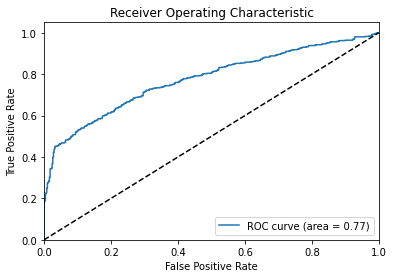

TAR@FAR:
    1%: 0.5280
  0.1%: 0.2740
 0.01%: 0.1840
0.001%: 0.1840
Accuracy: 0.714, Threshold: 0.7235840559005737


In [16]:
name='PA+Unsharp(radius=3, amount=1)'
enhance_params = {
    'image_size': image_size,
    'unsharp': 1,
    'unsharp_radius': 3,
    'unsharp_amount': 1
}
train_eval(name,'PA',enhance_params)

Files already downloaded and verified


Preprocessing Dataset...:   0%|          | 0/13233 [00:00<?, ?it/s]

Files already downloaded and verified
tensor([0.4863, 0.4073, 0.3547]) tensor([0.3248, 0.2905, 0.2774])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [44/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 457.9389 Best loss: 8.5028


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 23.927
R@2 : 28.819
R@4 : 34.320
R@8 : 39.202
R@16 : 43.381
R@32 : 47.465


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 20.766
R@2 : 26.429
R@4 : 31.392
R@8 : 36.084
R@16 : 40.777
R@32 : 46.305


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 7.2970
Files already downloaded and verified


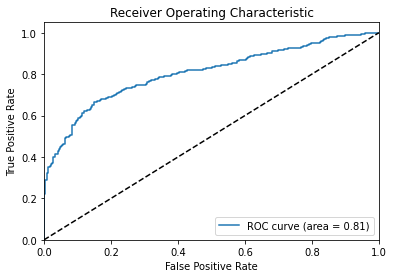

TAR@FAR:
    1%: 0.5840
  0.1%: 0.3240
 0.01%: 0.2220
0.001%: 0.2220
Accuracy: 0.757, Threshold: 0.6736579537391663


In [17]:
name='PA+Unsharp(radius=5, amount=1)'
enhance_params = {
    'image_size': image_size,
    'unsharp': 1,
    'unsharp_radius': 5,
    'unsharp_amount': 1
}
train_eval(name,'PA',enhance_params)

Files already downloaded and verified


Preprocessing Dataset...:   0%|          | 0/13233 [00:00<?, ?it/s]

Files already downloaded and verified
tensor([0.4798, 0.3973, 0.3452]) tensor([0.2695, 0.2400, 0.2344])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [43/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [44/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 452.2155 Best loss: 8.3206


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 24.199
R@2 : 29.995
R@4 : 35.307
R@8 : 39.969
R@16 : 44.063
R@32 : 46.698


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 17.907
R@2 : 23.355
R@4 : 28.425
R@8 : 33.792
R@16 : 38.592
R@32 : 43.177


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 5.9304
Files already downloaded and verified


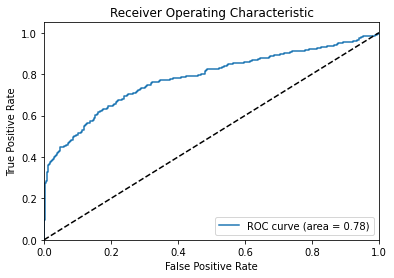

TAR@FAR:
    1%: 0.5120
  0.1%: 0.3280
 0.01%: 0.0940
0.001%: 0.0940
Accuracy: 0.728, Threshold: 0.7456260919570923


In [18]:
name='PA+Mean(size=3)'
enhance_params = {
    'image_size': image_size,
    'mean': 1,
    'mean_size': 3
}
train_eval(name,'PA',enhance_params)

Files already downloaded and verified


Preprocessing Dataset...:   0%|          | 0/13233 [00:00<?, ?it/s]

Files already downloaded and verified
tensor([0.4782, 0.3955, 0.3433]) tensor([0.2622, 0.2327, 0.2279])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [26/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [27/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [28/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [29/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [30/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [31/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [32/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [33/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [34/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [35/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [36/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [37/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [38/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [39/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [40/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [41/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [42/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [43/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [44/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 458.0804 Best loss: 8.3538


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 20.987
R@2 : 25.953
R@4 : 30.940
R@8 : 36.094
R@16 : 40.126
R@32 : 43.087


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 15.372
R@2 : 19.660
R@4 : 24.299
R@8 : 29.315
R@16 : 33.765
R@32 : 38.269


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 4.6150
Files already downloaded and verified
TAR@FAR:
    1%: 0.5020
  0.1%: 0.2420
 0.01%: 0.1040
0.001%: 0.1040
Accuracy: 0.709, Threshold: 0.7493578791618347


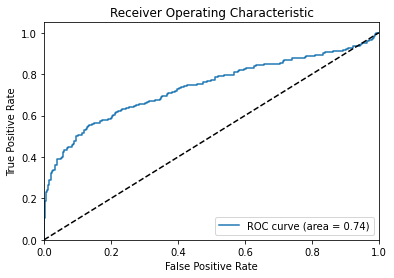

TAR@FAR:
    1%: 0.5020
  0.1%: 0.2420
 0.01%: 0.1040
0.001%: 0.1040
Accuracy: 0.709, Threshold: 0.7493578791618347


In [10]:
name='PA+Mean(size=5)'
enhance_params = {
    'image_size': image_size,
    'mean': 1,
    'mean_size': 5
}
train_eval(name,'PA',enhance_params)

Files already downloaded and verified


Preprocessing Dataset...:   0%|          | 0/13233 [00:00<?, ?it/s]

/workspace/Experiments/Clean/dataset/transform.py:175: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.22. Set `channel_axis=-1` explicitly to silence this warning.
  return gaussian(img, sigma=self.sigma)


Files already downloaded and verified
tensor([0.4808, 0.4010, 0.3469]) tensor([0.2731, 0.2444, 0.2387])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [26/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [27/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [28/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [29/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [30/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [31/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [32/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [33/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [34/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [35/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [36/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [37/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [38/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [39/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [40/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [41/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [42/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [43/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [44/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 460.6644 Best loss: 8.3420


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 27.265
R@2 : 32.588
R@4 : 37.680
R@8 : 42.026
R@16 : 45.680
R@32 : 48.115


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 20.065
R@2 : 25.539
R@4 : 30.717
R@8 : 35.922
R@16 : 40.588
R@32 : 44.525


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 6.8917
Files already downloaded and verified
TAR@FAR:
    1%: 0.5340
  0.1%: 0.3480
 0.01%: 0.2220
0.001%: 0.2220
Accuracy: 0.742, Threshold: 0.7458391785621643


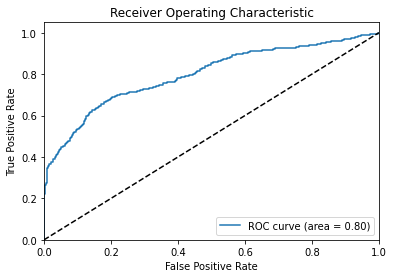

TAR@FAR:
    1%: 0.5340
  0.1%: 0.3480
 0.01%: 0.2220
0.001%: 0.2220
Accuracy: 0.742, Threshold: 0.7458391785621643


In [8]:
name='PA+Gaussian(sigma=.5)'
enhance_params = {
    'image_size': image_size,
    'gaussian': 1,
    'gaussian_sigma': .5
}
train_eval(name,'PA',enhance_params)

Files already downloaded and verified


Preprocessing Dataset...:   0%|          | 0/13233 [00:00<?, ?it/s]

/workspace/Experiments/Clean/dataset/transform.py:175: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.22. Set `channel_axis=-1` explicitly to silence this warning.
  return gaussian(img, sigma=self.sigma)


Files already downloaded and verified
tensor([0.4801, 0.3999, 0.3457]) tensor([0.2669, 0.2374, 0.2316])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [26/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [27/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [28/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [29/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [30/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [31/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [32/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [33/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [34/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [35/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [36/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [37/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [38/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [39/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [40/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [41/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [42/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [43/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [44/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 452.1940 Best loss: 8.4410


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 20.714
R@2 : 26.247
R@4 : 31.538
R@8 : 37.207
R@16 : 41.407
R@32 : 45.375


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 16.936
R@2 : 21.197
R@4 : 26.375
R@8 : 31.661
R@16 : 36.920
R@32 : 41.073


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 5.2960
Files already downloaded and verified


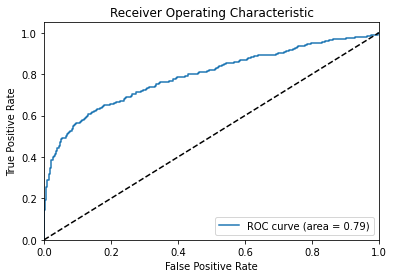

TAR@FAR:
    1%: 0.5660
  0.1%: 0.2880
 0.01%: 0.1440
0.001%: 0.1440
Accuracy: 0.737, Threshold: 0.6953800916671753


In [19]:
name='PA+Gaussian(sigma=1)'
enhance_params = {
    'image_size': image_size,
    'gaussian': 1,
    'gaussian_sigma': 1
}
train_eval(name,'PA',enhance_params)

Files already downloaded and verified


Preprocessing Dataset...:   0%|          | 0/13233 [00:00<?, ?it/s]

Files already downloaded and verified
tensor([0.4811, 0.4001, 0.3460]) tensor([0.2739, 0.2445, 0.2385])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [26/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [27/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [28/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [29/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [30/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [31/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [32/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [33/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [34/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [35/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [36/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [37/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [38/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [39/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [40/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [41/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [42/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [43/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [44/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 453.8011 Best loss: 8.3699


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 21.722
R@2 : 27.507
R@4 : 32.798
R@8 : 37.596
R@16 : 41.638
R@32 : 44.966


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 17.341
R@2 : 22.060
R@4 : 26.888
R@8 : 31.661
R@16 : 37.001
R@32 : 41.262


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 5.5512
Files already downloaded and verified


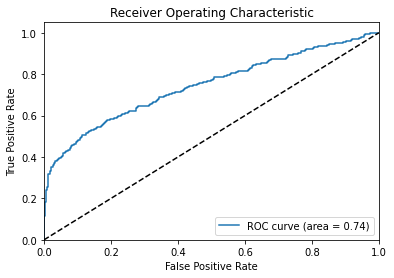

TAR@FAR:
    1%: 0.4800
  0.1%: 0.2560
 0.01%: 0.1160
0.001%: 0.1160
Accuracy: 0.695, Threshold: 0.7403171062469482


In [20]:
name='PA+Median(size=3)'
enhance_params = {
    'image_size': image_size,
    'median': 1,
    'median_size': 3
}
train_eval(name,'PA',enhance_params)

Files already downloaded and verified


Preprocessing Dataset...:   0%|          | 0/13233 [00:00<?, ?it/s]

Files already downloaded and verified
tensor([0.4823, 0.4003, 0.3456]) tensor([0.2723, 0.2422, 0.2359])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [26/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [27/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [28/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [29/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [30/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [31/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [32/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [33/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [34/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [35/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [36/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [37/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [38/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [39/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [40/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [41/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [42/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [43/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [44/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 459.4976 Best loss: 8.3366


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 24.924
R@2 : 30.604
R@4 : 36.010
R@8 : 40.703
R@16 : 44.420
R@32 : 47.223


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 17.934
R@2 : 22.816
R@4 : 28.047
R@8 : 33.414
R@16 : 38.565
R@32 : 42.799


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 5.6997
Files already downloaded and verified
TAR@FAR:
    1%: 0.5400
  0.1%: 0.2480
 0.01%: 0.1420
0.001%: 0.1420
Accuracy: 0.725, Threshold: 0.743516743183136


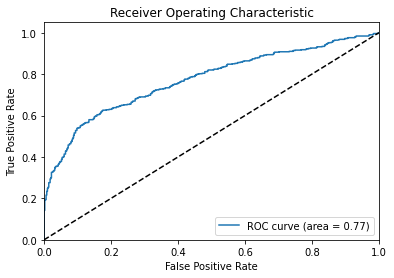

TAR@FAR:
    1%: 0.5400
  0.1%: 0.2480
 0.01%: 0.1420
0.001%: 0.1420
Accuracy: 0.725, Threshold: 0.743516743183136


In [7]:
name='PA+Median(size=5)'
enhance_params = {
    'image_size': image_size,
    'median': 1,
    'median_size': 5
}
train_eval(name,'PA',enhance_params)

Files already downloaded and verified


Preprocessing Dataset...:   0%|          | 0/13233 [00:00<?, ?it/s]

Files already downloaded and verified
tensor([0.5005, 0.4196, 0.3640]) tensor([0.2804, 0.2547, 0.2501])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [26/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [27/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [28/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [29/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [30/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [31/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [32/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [33/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [34/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [35/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [36/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [37/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [38/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [39/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [40/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [41/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [42/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [43/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [44/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 455.3622 Best loss: 8.3646


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 27.612
R@2 : 33.197
R@4 : 37.953
R@8 : 42.740
R@16 : 46.278
R@32 : 48.840


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 20.604
R@2 : 26.294
R@4 : 31.580
R@8 : 36.381
R@16 : 40.723
R@32 : 45.092


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 7.0590
Files already downloaded and verified


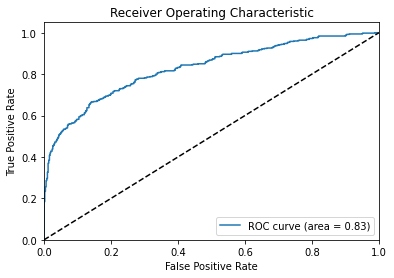

TAR@FAR:
    1%: 0.5820
  0.1%: 0.3260
 0.01%: 0.1840
0.001%: 0.1840
Accuracy: 0.762, Threshold: 0.7343284487724304


In [21]:
name='PA+Adapthist(clip_limit=.01)'
enhance_params = {
    'image_size': image_size,
    'hist': 1,
    'clip_limit': .01,
    'nbins': 512
}
train_eval(name,'PA',enhance_params)

Files already downloaded and verified


Preprocessing Dataset...:   0%|          | 0/13233 [00:00<?, ?it/s]

Files already downloaded and verified
tensor([0.5018, 0.4202, 0.3643]) tensor([0.2799, 0.2541, 0.2495])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [26/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [27/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [28/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [29/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [30/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [31/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [32/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [33/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [34/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [35/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 458.8031 Best loss: 8.4153


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 24.178
R@2 : 29.365
R@4 : 33.942
R@8 : 38.436
R@16 : 42.320
R@32 : 44.997


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 20.928
R@2 : 25.647
R@4 : 30.016
R@8 : 34.871
R@16 : 39.239
R@32 : 43.662


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 7.0358
Files already downloaded and verified


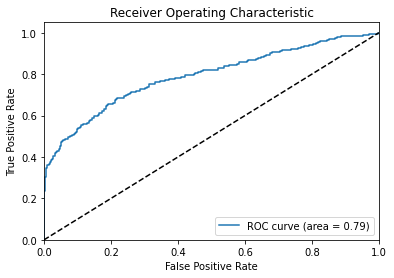

TAR@FAR:
    1%: 0.5360
  0.1%: 0.3600
 0.01%: 0.2360
0.001%: 0.2360
Accuracy: 0.733, Threshold: 0.6994090676307678


In [22]:
name='PA+Adapthist(clip_limit=.001)'
enhance_params = {
    'image_size': image_size,
    'hist': 1,
    'clip_limit': .001,
    'nbins': 512
}
train_eval(name,'PA',enhance_params)

Files already downloaded and verified


Preprocessing Dataset...:   0%|          | 0/13233 [00:00<?, ?it/s]

Files already downloaded and verified
tensor([0.4928, 0.4194, 0.3649]) tensor([0.2812, 0.2563, 0.2492])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9/50]:   0%|          | 0/75 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 456.5869 Best loss: 8.4440


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 21.270
R@2 : 26.394
R@4 : 31.150
R@8 : 35.885
R@16 : 39.192
R@32 : 41.942


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 19.714
R@2 : 24.245
R@4 : 28.425
R@8 : 32.767
R@16 : 37.783
R@32 : 41.289


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 6.2571
Files already downloaded and verified


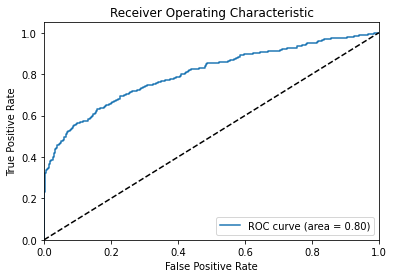

TAR@FAR:
    1%: 0.5620
  0.1%: 0.3400
 0.01%: 0.2320
0.001%: 0.2320
Accuracy: 0.735, Threshold: 0.7161813378334045


In [23]:
name='PA+AutoContrast'
enhance_params = {
    'image_size': image_size,
    'autocontrast': 1
}
train_eval(name,'PA',enhance_params)

Files already downloaded and verified


Preprocessing Dataset...:   0%|          | 0/13233 [00:00<?, ?it/s]

Files already downloaded and verified
tensor([0.5370, 0.4466, 0.3857]) tensor([0.2777, 0.2476, 0.2439])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [44/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 456.7425 Best loss: 8.4678


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 22.331
R@2 : 27.297
R@4 : 32.273
R@8 : 37.113
R@16 : 41.270
R@32 : 44.430


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 16.343
R@2 : 21.926
R@4 : 27.373
R@8 : 32.659
R@16 : 37.487
R@32 : 42.098


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 5.5549
Files already downloaded and verified


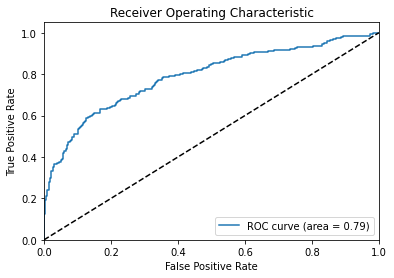

TAR@FAR:
    1%: 0.5200
  0.1%: 0.2400
 0.01%: 0.1260
0.001%: 0.1260
Accuracy: 0.732, Threshold: 0.7145291566848755


In [24]:
name='PA+AdjustLog'
enhance_params = {
    'image_size': image_size,
    'adjust_log': 1,
    'adjust_log_gain': 1,
}
train_eval(name,'PA',enhance_params)

Files already downloaded and verified
Files already downloaded and verified
tensor([0.4878, 0.4034, 0.3514]) tensor([0.2859, 0.2520, 0.2462])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [26/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [27/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [28/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [29/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [30/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [31/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [32/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [33/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [34/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [35/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [36/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [37/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [38/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [39/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [40/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [41/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [42/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [43/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [44/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 1253.1486 Best loss: 8.2413


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 31.748
R@2 : 37.323
R@4 : 42.982
R@8 : 47.202
R@16 : 50.373
R@32 : 52.420


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 23.463
R@2 : 28.371
R@4 : 33.522
R@8 : 38.700
R@16 : 43.770
R@32 : 47.438


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 8.8042
Files already downloaded and verified
TAR@FAR:
    1%: 0.5780
  0.1%: 0.4060
 0.01%: 0.2620
0.001%: 0.2620
Accuracy: 0.755, Threshold: 0.7642514109611511


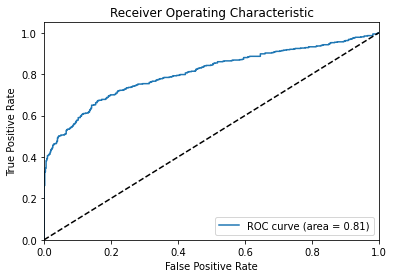

TAR@FAR:
    1%: 0.5780
  0.1%: 0.4060
 0.01%: 0.2620
0.001%: 0.2620


In [6]:
name='PA+GFPGAN'
enhance_params = {}
train_eval(name,'PA',enhance_params,gfpgan=True)

Train:
R@1: 23.632545931758532
R@2: 28.619422572178475
R@4: 33.56430446194226
R@8: 38.44619422572178
R@16: 42.813648293963254
R@32: 46.39370078740158
Test:
R@1: 20.010787486515643
R@2: 25.5663430420712
R@4: 30.960086299892126
R@8: 35.94929881337649
R@16: 40.80366774541532
R@32: 45.73894282632146
MAP@R: 6.798947811126709
Accuracy: 0.766
Threshold: 0.6918678283691406


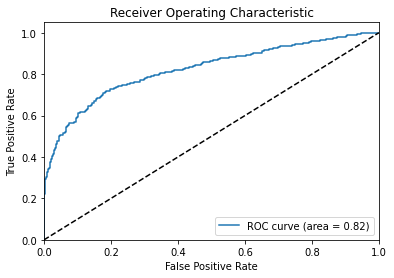

TAR@FAR:
    1%: 0.6100
  0.1%: 0.3280
 0.01%: 0.2200
0.001%: 0.2200


In [28]:
name='PA+GFPGAN+Adapthist(clip_limit=.01)+Unsharp(radius=5, amount=1)'
test_params = {
    'split': 'test',
    'random': 0,
    'image_size': image_size,
    'face_detection': 1,
    'pad_ratio': 1.6
}
enhance_params = {
    'image_size': image_size,
    'hist': 1,
    'clip_limit': .01,
    'nbins': 512,
    'unsharp': 1,
    'unsharp_radius': 5,
    'unsharp_amount': 1,
}
train_eval(name,'PA',enhance_params, gfpgan=True, load_saved=True)

Files already downloaded and verified


Preprocessing Dataset...:   0%|          | 0/13233 [00:00<?, ?it/s]

/workspace/Experiments/Clean/dataset/transform.py:175: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.22. Set `channel_axis=-1` explicitly to silence this warning.
  return gaussian(img, sigma=self.sigma)


Files already downloaded and verified
tensor([0.5047, 0.4197, 0.3664]) tensor([0.2816, 0.2523, 0.2484])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [26/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [27/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [28/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [29/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [30/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [31/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [32/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [33/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [34/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [35/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [36/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [37/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [38/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [39/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [40/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [41/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [42/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [43/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [44/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 460.1619 Best loss: 8.3481


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 23.990
R@2 : 29.186
R@4 : 34.373
R@8 : 39.108
R@16 : 43.412
R@32 : 46.436


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 18.959
R@2 : 23.921
R@4 : 29.234
R@8 : 34.951
R@16 : 40.561
R@32 : 45.469


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 6.6704
Files already downloaded and verified
TAR@FAR:
    1%: 0.5680
  0.1%: 0.3480
 0.01%: 0.1760
0.001%: 0.1760
Accuracy: 0.753, Threshold: 0.7245717644691467


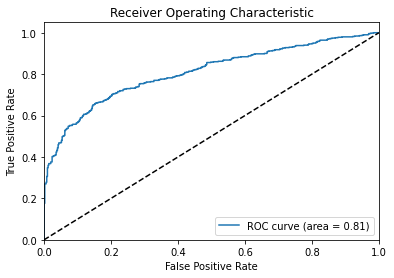

TAR@FAR:
    1%: 0.5680
  0.1%: 0.3480
 0.01%: 0.1760
0.001%: 0.1760


In [35]:
name='PA+GFPGAN+Adapthist(clip_limit=.01)+Gaussian(sigma=.5)'
test_params = {
    'split': 'test',
    'random': 0,
    'image_size': image_size,
    'face_detection': 1,
    'pad_ratio': 1.6
}
enhance_params = {
    'image_size': image_size,
    'hist': 1,
    'clip_limit': .01,
    'nbins': 512,
    'gaussian': 1,
    'gaussian_sigma': .5
}
train_eval(name,'PA',enhance_params, gfpgan=True)

Train:
R@1: 25.858267716535433
R@2: 31.443569553805773
R@4: 36.367454068241464
R@8: 40.78740157480315
R@16: 44.36745406824147
R@32: 47.044619422572175
Test:
R@1: 21.197411003236247
R@2: 26.26752966558792
R@4: 31.984897518878103
R@8: 37.24379719525351
R@16: 42.74541531823085
R@32: 46.81769147788565
MAP@R: 7.648918151855469
Accuracy: 0.741
Threshold: 0.7272026538848877


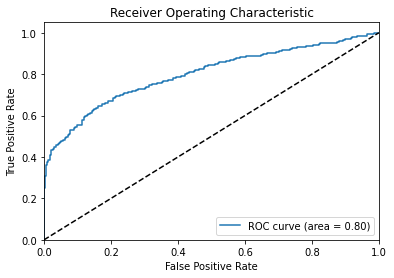

TAR@FAR:
    1%: 0.5520
  0.1%: 0.3760
 0.01%: 0.2520
0.001%: 0.2520


In [27]:
name='PA+GFPGAN+Adapthist(clip_limit=.01)'
test_params = {
    'split': 'test',
    'random': 0,
    'image_size': image_size,
    'face_detection': 1,
    'pad_ratio': 1.6
}
enhance_params = {
    'image_size': image_size,
    'hist': 1,
    'clip_limit': .001,
    'nbins': 512,
}
train_eval(name,'PA',enhance_params, gfpgan=True, load_saved=True)

Files already downloaded and verified
Files already downloaded and verified
tensor([0.4861, 0.4022, 0.3506]) tensor([0.2855, 0.2521, 0.2463])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [26/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [27/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [28/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [29/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [30/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [31/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [32/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [33/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [34/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [35/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [36/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [37/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [38/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [39/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [40/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [41/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [42/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [43/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [44/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 1255.2653 Best loss: 8.2933


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 29.323
R@2 : 34.950
R@4 : 40.042
R@8 : 45.134
R@16 : 49.071
R@32 : 51.790


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 20.820
R@2 : 26.483
R@4 : 31.338
R@8 : 36.570
R@16 : 41.559
R@32 : 46.386


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 7.2763
Files already downloaded and verified
TAR@FAR:
    1%: 0.6080
  0.1%: 0.3720
 0.01%: 0.1320
0.001%: 0.1320
Accuracy: 0.758, Threshold: 0.7354304790496826


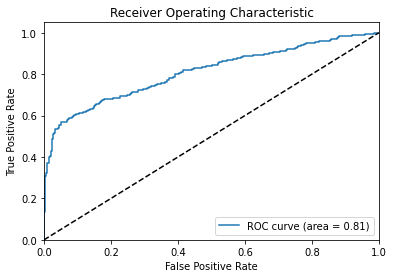

TAR@FAR:
    1%: 0.6080
  0.1%: 0.3720
 0.01%: 0.1320
0.001%: 0.1320


In [24]:
name='PA+GFPGAN'
test_params = {
    'split': 'test',
    'random': 0,
    'image_size': image_size,
    'face_detection': 1,
    'pad_ratio': 1.6
}
enhance_params = {}
train_eval(name,'PA',enhance_params, gfpgan=True)

Files already downloaded and verified
Files already downloaded and verified
tensor([0.4835, 0.4028, 0.3485]) tensor([0.2802, 0.2507, 0.2447])
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [26/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [27/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [28/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [29/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [30/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [31/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [32/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [33/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [34/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [35/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [36/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [37/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [38/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [39/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [40/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [41/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [42/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [43/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [44/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [45/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [46/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [47/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [48/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [49/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [50/50]:   0%|          | 0/75 [00:00<?, ?it/s]

Finished Training, Time: 498.9551 Best loss: -2836.5311


  0%|          | 0/75 [00:00<?, ?it/s]

R@1 : 4.913
R@2 : 7.276
R@4 : 10.499
R@8 : 14.593
R@16 : 19.580
R@32 : 24.745


  0%|          | 0/29 [00:00<?, ?it/s]

R@1 : 9.385
R@2 : 13.403
R@4 : 17.907
R@8 : 23.193
R@16 : 27.994
R@32 : 33.954


  0%|          | 0/29 [00:00<?, ?it/s]

MAP@R: 2.5481
Files already downloaded and verified
TAR@FAR:
    1%: 0.3920
  0.1%: 0.1880
 0.01%: 0.0260
0.001%: 0.0260
Accuracy: 0.684, Threshold: 0.6712284088134766


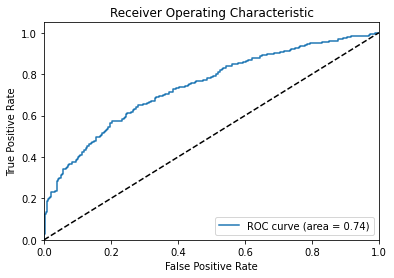

TAR@FAR:
    1%: 0.3920
  0.1%: 0.1880
 0.01%: 0.0260
0.001%: 0.0260


In [6]:
name='PFE'
test_params = {
    'split': 'test',
    'random': 0,
    'image_size': image_size,
}
enhance_params = {}
train_eval(name,'PFE',enhance_params,
           model_name='pfe',
           loss_func_name='mutual_likelihood_score',
           drop_last=True)

Train:
R@1: 3.286089238845144
R@2: 5.1128608923884515
R@4: 8.031496062992126
R@8: 11.79002624671916
R@16: 15.706036745406823
R@32: 20.178477690288716
Test:
R@1: 7.84789644012945
R@2: 10.382955771305285
R@4: 14.13160733549083
R@8: 19.47141316073355
R@16: 25.05393743257821
R@32: 31.202804746494067
MAP@R: 1.9313409328460693
Accuracy: 0.648
Threshold: 0.6952505707740784


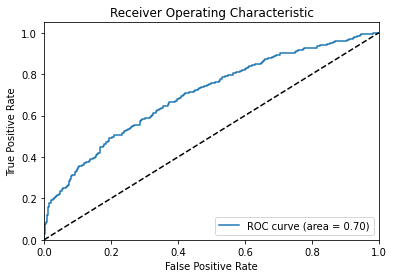

TAR@FAR:
    1%: 0.3480
  0.1%: 0.1200
 0.01%: 0.0300
0.001%: 0.0300


In [24]:
name='PFE+Adapthist(clip_limit=.001)+Unsharp(radius=5, amount=1)'
test_params = {
    'split': 'test',
    'random': 0,
    'image_size': image_size,
    'face_detection': 1,
    'pad_ratio': 1.6
}
enhance_params = {
    'image_size': image_size,
    'hist': 1,
    'clip_limit': .001,
    'nbins': 512,
    'unsharp': 1,
    'unsharp_radius': 5,
    'unsharp_amount': 1,
}
train_eval(name,'PFE',enhance_params,
           model_name='pfe',
           loss_func_name='mutual_likelihood_score',
           drop_last=True,
           eval_only=True
          )